In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(style='darkgrid', font_scale=0.9)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data = np.load("/content/gdrive/My Drive/ProjektML/bengali-small-split.npz")
X_train = data["img_train"]
X_test = data["img_test"]
Y_train = data["target_train"]
Y_test = data["target_test"]

# Bengali character recognition

<figure>
<img src='https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1095143%2Fa9a48686e3f385d9456b59bf2035594c%2Fdesc.png?generation=1576531903599785&alt=media' width=600 height=600 />
<figcaption>Bengali characters consist of three components</figcaption> 
</figure>

This dataset contains images of hand-written Bengali characters. Bengali characters (graphemes) are consisted of three components: a grapheme_root, vowel_diacritic, and consonant_diacritic. The challenge is to classify the components of the grapheme in each image. There are roughly 10,000 possible graphemes, of which only a part is represented in the training set. 

## Data presentation

Text(0.5, 0.98, 'Data samples with targets')

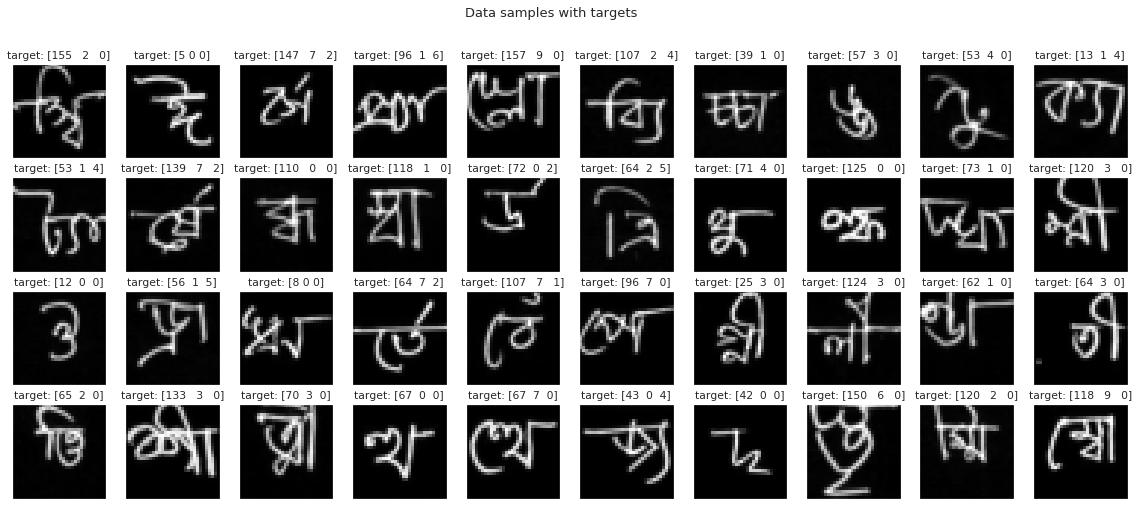

In [0]:
plt.figure(figsize=(20, 8))

for i in range(40):
  plt.subplot(4, 10, i+1)
  plt.imshow(X_train[i], cmap='gray')

  plt.xticks([]); plt.yticks([])
  plt.title(f'target: {Y_train[i]}')
plt.suptitle("Data samples with targets")

> Presentation of data samples with respective classes

### Target statistics

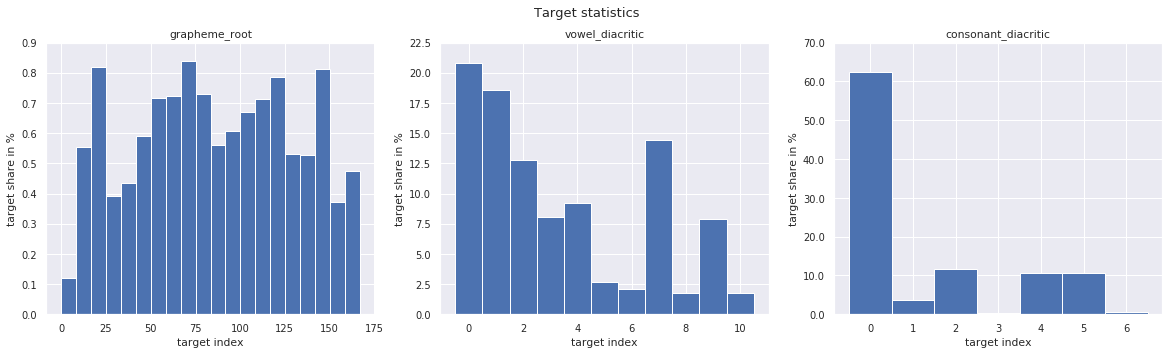

In [0]:
num_bins = [169, 12, 8]
idx_to_name = ['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']

plt.figure(figsize=(20, 5))
for target_idx in range(3):
  plt.subplot(1, 3, target_idx+1)

  bins = num_bins[target_idx]

  if bins < 20:
    bins = np.arange(bins)-0.5
  else:
    bins = 20

  plt.hist(Y_train[:, target_idx], density=True, bins=bins)

  ticks = plt.yticks()[0]
  new_ticks = np.round(ticks * 100, 1)
  plt.yticks(ticks, new_ticks)

  plt.ylabel('target share in %')
  plt.xlabel('target index')

  plt.title(idx_to_name[target_idx])
  plt.suptitle("Target statistics")

> Distribution of classes for each target

Classes are not balanced, especially in constant_diactric target!

Moreover, the different targets combination gives different character.
### How many unique combination are there?

In [0]:
from collections import Counter
Y_tup = [tuple(y) for y in Y_train]
counts = Counter(Y_tup)
sorted_common_target = counts.most_common()

print(f'number of different combinations: {len(counts)}')
print(f'mode: {sorted_common_target[0][0]} with {sorted_common_target[0][1]} occurences')
print(f'least common: {sorted_common_target[-1][0]} with {sorted_common_target[-1][1]} occurences')

number of different combinations: 1292
mode: (167, 7, 0) with 68 occurences
least common: (72, 9, 2) with 12 occurences


Suprisingly, the least common class is not that rare at all.

### Presentation of the mode

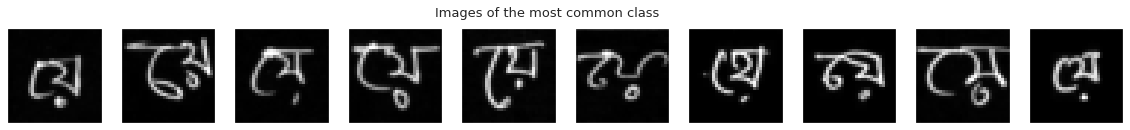

In [0]:
modes = [idx for idx, tup in enumerate(Y_tup) if tup == (167, 7, 0)]
X_modes = X_train[modes]

fig = plt.figure(figsize=(20, 2))
fig.suptitle('Images of the most common class')

for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.imshow(X_modes[-i], cmap='gray')
  plt.xticks([]); plt.yticks([])

> Presentation of samples from the most common set of classes. Clearly, images from the same class can look very different.

## Data compression

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca2d = pca.fit_transform(X_train.reshape(-1, 32*32))

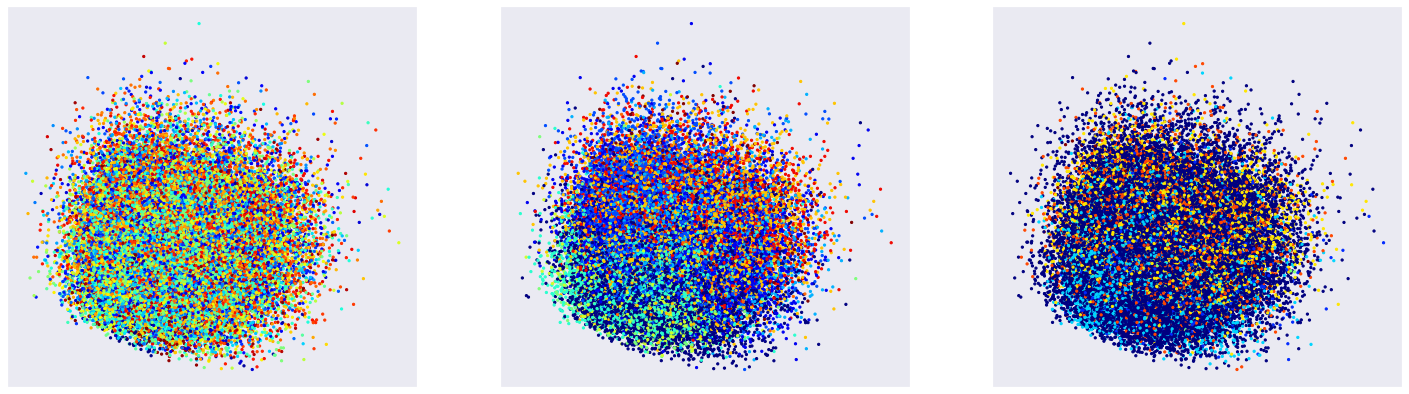

In [0]:
plt.figure(figsize=(25, 7))

for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.scatter(X_pca2d[:, 0], X_pca2d[:, 1], s=5, c=Y_train[:, i], cmap="jet")
  plt.xticks([]); plt.yticks([]);


> Presentation of data reduced using PCA. Each figure shows a different target.



Such extreme (from 1024 to 2 dimensions) does not preserve much informations (if any).

We will analyse it.

### Image reconstruction from PCA

#### Original Image

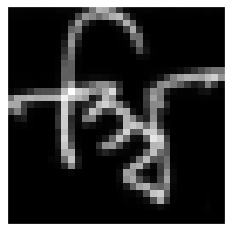

In [0]:
img = X_train[0, :]

def show_one(img):
  plt.imshow(img, cmap='gray')
  plt.grid([]); plt.xticks([]); plt.yticks([]);

show_one(img)

#### Reconstructions


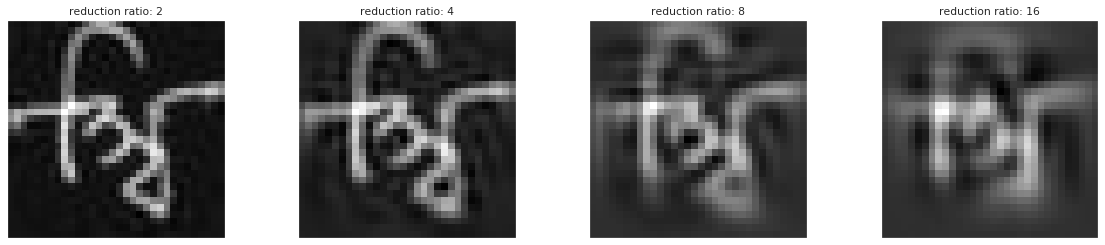

In [0]:
h, w = img.shape
original_size = h * w

plt.figure(figsize=(20, 4))

for idx, reduction in enumerate([2, 4, 8, 16]):
  pca = PCA(n_components=original_size//reduction)
  pca.fit(X_train.reshape(-1, original_size))

  img_pca = pca.transform(img.reshape(1, original_size))
  img_reconstructed = pca.inverse_transform(img_pca).reshape(h, w)

  plt.subplot(1, 4, idx+1)
  show_one(img_reconstructed)
  plt.title(f'reduction ratio: {reduction}')

> Reconstructed images for different dimensionality reduction ratios

#### Variance analysis

We can see that data can be reduced twice without losing much variance, but further reduction might be losing the variance.

We will check exactly how much variance we lose.

In [0]:
pca = PCA(n_components=original_size)
pca.fit(X_train.reshape(-1, original_size))

explained_variance = pca.explained_variance_ratio_

In [0]:
interesting_idx = list(range(10)) + list(range(10, 100, 10)) + list(range(100, 1000, 100))

for idx, value in enumerate(np.cumsum(explained_variance)):
  if idx+1 in interesting_idx:
    print(f'component: {idx+1:>4}, explained variance: {value*100:<6.3f}%')

component:    1, explained variance: 3.758 %
component:    2, explained variance: 7.338 %
component:    3, explained variance: 10.373%
component:    4, explained variance: 12.993%
component:    5, explained variance: 15.513%
component:    6, explained variance: 17.868%
component:    7, explained variance: 20.158%
component:    8, explained variance: 22.272%
component:    9, explained variance: 24.056%
component:   10, explained variance: 25.719%
component:   20, explained variance: 38.371%
component:   30, explained variance: 46.573%
component:   40, explained variance: 53.068%
component:   50, explained variance: 58.338%
component:   60, explained variance: 62.706%
component:   70, explained variance: 66.391%
component:   80, explained variance: 69.542%
component:   90, explained variance: 72.280%
component:  100, explained variance: 74.660%
component:  200, explained variance: 88.297%
component:  300, explained variance: 93.951%
component:  400, explained variance: 96.758%
component:

As we can see, we were right and we need 500 dimensions to keep most of the variance.

### t-SNE visualization

In [0]:
%%capture
# capture supresses output

# We install miniconda and fast cuda implementation of tsne - because of a few thousand times speedup
# Make sure to use GPU runtime

!wget -q https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local > nul
sys.path.append('/usr/local/lib/python3.6/site-packages')
!conda install -y -q -c cannylab tsnecuda 

In [0]:
from sklearn.decomposition import PCA
from tsnecuda import TSNE as TSNE_cuda
X_prepared = PCA(600).fit_transform(X_train.reshape(-1, 32*32))
embedded = TSNE_cuda(2, perplexity=30, early_exaggeration=3.0).fit_transform(X_prepared)

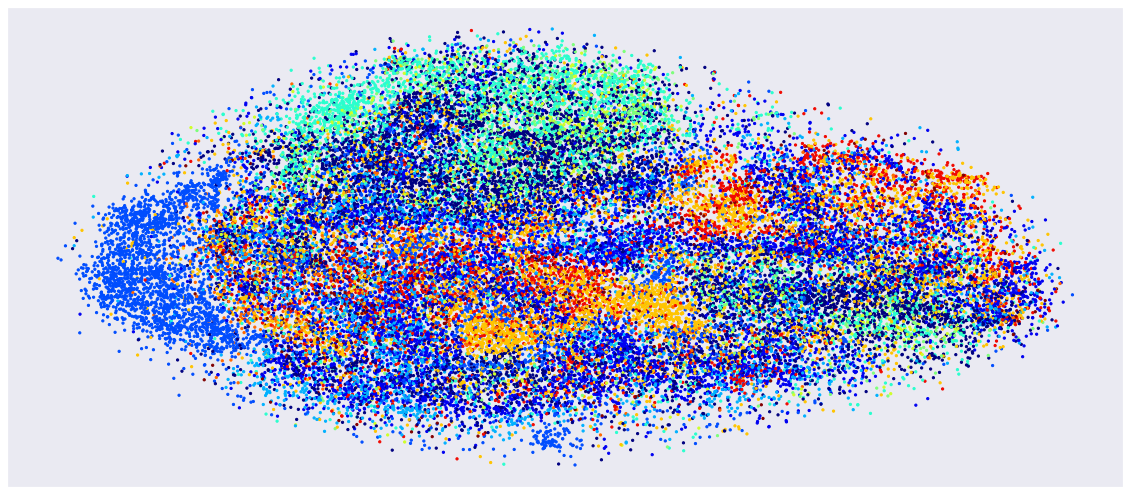

In [0]:
plt.figure(figsize=(20, 30))

for i in [1]:
  plt.subplot(3, 1, i+1)
  plt.scatter(embedded[:, 0], embedded[:, 1], s=5, c=Y_train[:, i], cmap="jet")
  plt.xticks([]); plt.yticks([]);

> t-SNE visualisation of the data. The marked target is vowel diacritic.

Such visualization can hardly give us satisfying results, since we have 3 different classes in the dataset. But we finally see that some classes are separated.

## Classic approaches to classification

### K Nearest Neighbors

kNN on PCA-reduced datapoints. We will consider each target separately. First, we try to predict the first target - grapheme root. With 168 different classes, it is probably the most difficult one. We will look at two metrics - accuracy score and macro recall, which is just an arithmetic mean of recall scores calculated for each class. While the accuracy metric attaches more significance to more represented classes, macro recall treats every class as equally important.

In [0]:
from sklearn.decomposition import PCA

pca = PCA(50, whiten=False)
X_prepared = pca.fit_transform(X_train.reshape(-1, 32 * 32))
X_test_prepared = pca.transform(X_test.reshape(-1, 32 * 32))

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

preds0 = {}

for k in [1, 3, 7, 11, 17, 29]:
  knn = KNeighborsClassifier(k, n_jobs=-1)
  knn.fit(X_prepared, Y_train[:, 0])
  preds0[k] = knn.predict(X_test_prepared)

In [0]:
for k, p in preds0.items():
    print(f'{k}-NN accuracy: {100 * np.mean(p == Y_test[:, 0]):6.2f}%')
    print(f"{k}-NN macro recall: {100 * metrics.recall_score(Y_test[:, 0], p, average='macro'):.2f}%")

1-NN accuracy:  11.33%
1-NN macro recall: 10.81%
3-NN accuracy:   9.47%
3-NN macro recall: 8.73%
7-NN accuracy:  10.83%
7-NN macro recall: 8.83%
11-NN accuracy:  11.80%
11-NN macro recall: 9.06%
17-NN accuracy:  12.65%
17-NN macro recall: 8.59%
29-NN accuracy:  12.98%
29-NN macro recall: 7.93%


We can see that increasing the value of $k$ tends to increase the accuracy and decrease the macro recall. This suggests that the model performs better on samples from more represented classes while performing worse on other samples. This is consistent with our intuition of data points having more neighbors from overrepresented classes.

Next, we check the vowel diacritic target.

In [0]:
preds1 = {}

for k in [1, 3, 7, 11, 17, 29]:
  knn = KNeighborsClassifier(k, n_jobs=-1)
  knn.fit(X_prepared, Y_train[:, 1])
  preds1[k] = knn.predict(X_test_prepared)

In [0]:
for k, p in preds1.items():
    print(f'{k}-NN accuracy: {100 * np.mean(p == Y_test[:, 1]):6.2f}%')
    print(f"{k}-NN macro recall: {100 * metrics.recall_score(Y_test[:, 1], p, average='macro'):.2f}%")

1-NN accuracy:  53.94%
1-NN macro recall: 44.65%
3-NN accuracy:  56.70%
3-NN macro recall: 41.89%
7-NN accuracy:  60.88%
7-NN macro recall: 44.60%
11-NN accuracy:  62.06%
11-NN macro recall: 44.67%
17-NN accuracy:  62.70%
17-NN macro recall: 44.13%
29-NN accuracy:  62.79%
29-NN macro recall: 43.08%


The decrease in the number of classes allowed our model to be much more effective, although the effects of class imbalance are still visible.

Finally, we check the consonant diacritic target. While it has the smallest number of possible classes, it suffers from severe class imbalance, with roughly 60% of training samples belonging to class 0.

In [0]:
preds2 = {}

for k in [1, 3, 7, 11, 17, 29]:
  knn = KNeighborsClassifier(k, n_jobs=-1)
  knn.fit(X_prepared, Y_train[:, 2])
  preds2[k] = knn.predict(X_test_prepared)

In [0]:
for k, p in preds2.items():
    print(f'{k}-NN accuracy: {100 * np.mean(p == Y_test[:, 2]):6.2f}%')
    print(f"{k}-NN macro recall: {100 * metrics.recall_score(Y_test[:, 2], p, average='macro'):.2f}%")

1-NN accuracy:  56.13%
1-NN macro recall: 29.38%
3-NN accuracy:  63.49%
3-NN macro recall: 24.94%
7-NN accuracy:  65.59%
7-NN macro recall: 22.81%
11-NN accuracy:  65.33%
11-NN macro recall: 21.39%
17-NN accuracy:  65.45%
17-NN macro recall: 19.25%
29-NN accuracy:  65.06%
29-NN macro recall: 17.84%


We can observe a large difference between the two metrics, which, as before, tends to increase with an increase of k. Since now we are dealing with a small number of classes we can examine the confusion matrices.

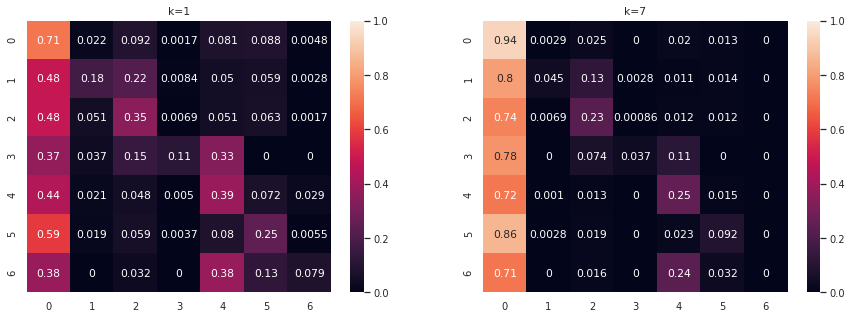

In [0]:
fig, ax = plt.subplots(figsize=(15, 5), ncols=2)

for axis, k in zip(ax, [1, 7]):
    cm = metrics.confusion_matrix(Y_test[:, 2], preds2[k], normalize="true")
    sns.heatmap(cm, annot=True, ax=axis, vmin=0., vmax=1.)
    axis.set_title(f"k={k}")

> Confusion matrices for the kNN classifier with different values of k

While the recall value for class 0 reaches 94% for k=7, we can see that an increase of k caused the model to perform noticeably worse on samples from other classes. In fact, no samples from classes 3 and 6 were classified correctly in the latter case and every class has at least 70% of samples classified as belonging to class 0.

### SVM

In [0]:
# we will use an SVM implementation for CUDA: https://github.com/Xtra-Computing/thundersvm
!pip install -q https://github.com/Xtra-Computing/thundersvm/releases/download/v0.3.4/thundersvm_cuda10.1-0.3.4-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 522kB 600kB/s 


We will start with a binary problem of distinguishing between the class 0 of the consonant diacritic target vs the other classes (i.e. detecting presence of a consonant diacritic).

In [0]:
import thundersvm
from sklearn import decomposition, metrics

In [0]:
pca = decomposition.PCA(n_components=50)
X_train_prep = pca.fit_transform(X_train.reshape(-1, 32*32))
X_test_prep = pca.transform(X_test.reshape(-1, 32*32))

Y_train_prep = np.where(Y_train[:, 2] == 0, 0, 1)
Y_test_prep = np.where(Y_test[:, 2] == 0, 0, 1)

In [0]:
pd.value_counts(Y_train_prep, normalize=True)

0    0.62375
1    0.37625
dtype: float64

The class ratio is 60% to 40% so the problem is rather balanced.

In [0]:
%%time
gamma = 1. / (X_train_prep.shape[1] * np.var(X_train_prep)) # default in sklearn, not implemented in thundersvm
c = thundersvm.SVC(C=10, gamma=gamma)
c.fit(X_train_prep, Y_train_prep)

CPU times: user 9.06 s, sys: 7.34 s, total: 16.4 s
Wall time: 16.5 s


In [0]:
preds = c.predict(X_test_prep)
print(f"Accuracy: {100 * metrics.accuracy_score(Y_test_prep, preds):.2f}%")
print(f"Macro recall: {100 * metrics.recall_score(Y_test_prep, preds, average='macro'):.2f}%")

Accuracy: 72.11%
Macro recall: 69.20%


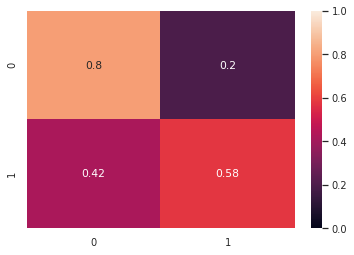

In [0]:
sns.heatmap(metrics.confusion_matrix(Y_test_prep, preds, normalize="true"), annot=True, vmin=0., vmax=1.)

> Confusion matrix for an SVM detecting presence of a consonant diacritic

Since we're performing the calculations on a GPU the computation time wasn't bad. Next we try the full classiffication problems with the one-vs-one approach.

In [0]:
c = thundersvm.SVC(C=10, gamma=gamma, decision_function_shape="ovo")
c.fit(X_train_prep, Y_train[:, 0])
preds0 = c.predict(X_test_prep)
print(f"Accuracy: {100 * metrics.accuracy_score(Y_test[:, 0], preds0):.2f}%")
print(f"Macro recall: {100 * metrics.recall_score(Y_test[:, 0], preds0, average='macro'):.2f}%")

Accuracy: 22.06%
Macro recall: 15.56%


In [0]:
c = thundersvm.SVC(C=10, gamma=gamma, decision_function_shape="ovo")
c.fit(X_train_prep, Y_train[:, 1])
preds1 = c.predict(X_test_prep)
print(f"Accuracy: {100 * metrics.accuracy_score(Y_test[:, 1], preds1):.2f}%")
print(f"Macro recall: {100 * metrics.recall_score(Y_test[:, 1], preds1, average='macro'):.2f}%")

Accuracy: 72.79%
Macro recall: 62.99%


In [0]:
c = thundersvm.SVC(C=10, gamma=gamma, decision_function_shape="ovo")
c.fit(X_train_prep, Y_train[:, 2])
preds2 = c.predict(X_test_prep)
print(f"Accuracy: {100 * metrics.accuracy_score(Y_test[:, 2], preds2):.2f}%")
print(f"Macro recall: {100 * metrics.recall_score(Y_test[:, 2], preds2, average='macro'):.2f}%")

Accuracy: 71.64%
Macro recall: 38.52%


Overall, SVM performs better then kNN for all subproblems, for all tested values of k and for both metrics. We can also check the accuracy for the whole task.

In [0]:
overall_accuracy = np.mean((preds0 == Y_test[:, 0]) & (preds1 == Y_test[:, 1]) & (preds2 == Y_test[:, 2]))
print(f"{100 * overall_accuracy}%")

12.24%


### Random forest classification

In [0]:
from sklearn import ensemble, metrics

Unlike the previous classifiers, we train the random forest classifier without dimensionality reduction. This will give us insight into the importance of each feature for each subproblem.

In [0]:
preds = []
feature_importances = []

for c in range(3):
    rf = ensemble.RandomForestClassifier(criterion="gini", n_jobs=-1, verbose=1)
    rf.fit(X_train.reshape(-1, 32*32), Y_train[:, c])
    preds.append(rf.predict(X_test.reshape(-1, 32*32)))
    feature_importances.append(rf.feature_importances_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   59.0s
[Parall

In [0]:
idx_to_name = ['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']
for c in range(3):
    print(f"{idx_to_name[c]} accuracy: {100 * metrics.accuracy_score(Y_test[:, c], preds[c]):.2f}%")
    print(f"{idx_to_name[c]} macro recall: {100 * metrics.recall_score(Y_test[:, c], preds[c], average='macro'):.2f}%")

grapheme_root accuracy: 8.59%
grapheme_root macro recall: 4.08%
vowel_diacritic accuracy: 60.77%
vowel_diacritic macro recall: 42.03%
consonant_diacritic accuracy: 70.29%
consonant_diacritic macro recall: 24.25%


The classifiers' performance is comparable to that of kNN classifiers. We can now examine the feature importance scores.

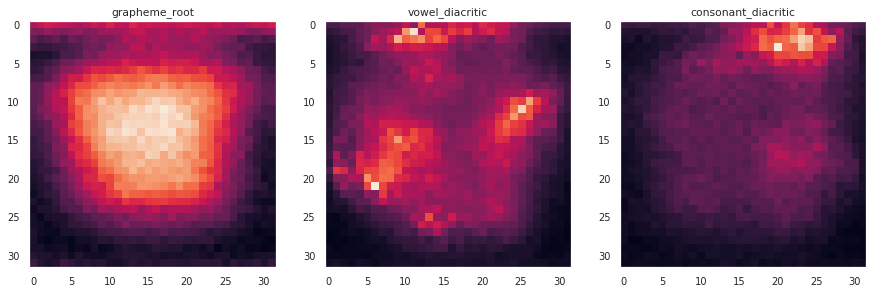

In [0]:
fig, ax = plt.subplots(figsize=(15, 7), ncols=3)
for c in range(3):
    ax[c].imshow(feature_importances[c].reshape(32, 32))
    ax[c].grid(None)
    ax[c].set_title(idx_to_name[c])

> Importance scores calculated for each pixel using a random forest

We can see which parts of an image are of greatest importance for each of the subproblems. In praticular, for grapheme root prediction the central part of the image seems to be most important, whereas diacritic predictions require more focus on the edges of a grapheme.

## Segmentation

Since Bengali characters are composed of parts which are to be classified in each of the subproblems, it seems natural to try to split the grapheme into its components to simplify each of the classification tasks. We'll begin by looking at the results of a nonnegative matrix factorization.

In [0]:
from sklearn import decomposition
nmf = decomposition.NMF(n_components=15)
nmf.fit(X_train.reshape(-1, 32*32))

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=15, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

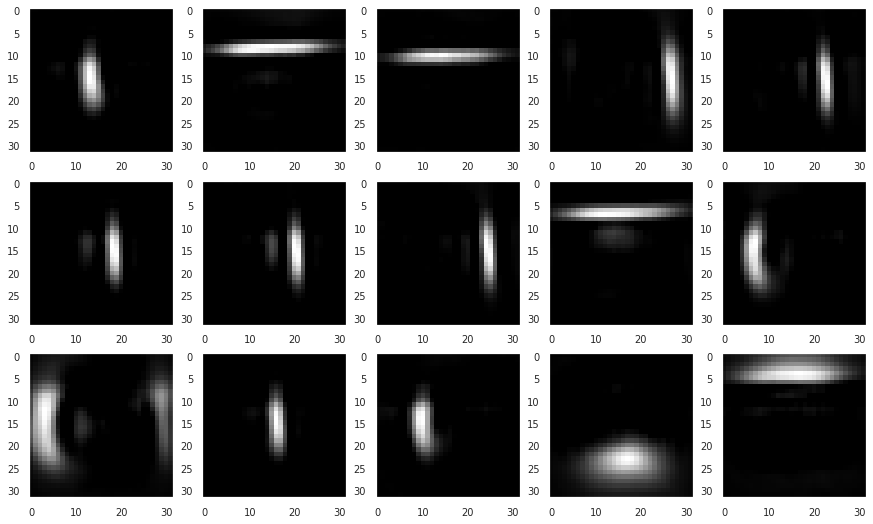

In [0]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
for ax, component in zip(axes.flatten(), nmf.components_):
    ax.imshow(component.reshape(32, 32), cmap="gray")
    ax.grid(None)

> Presentation of the components for a low rank NMF


Running NMF with a low rank allowed to approximately mfdecompose the graphemes into a set of small components. We can try to increase the value of this paramter to potentially include all possible grapheme components, such as the diacritics.

In [0]:
nmf1 = decomposition.NMF(n_components=200)
nmf1.fit(X_train.reshape(-1, 32*32))

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=200, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

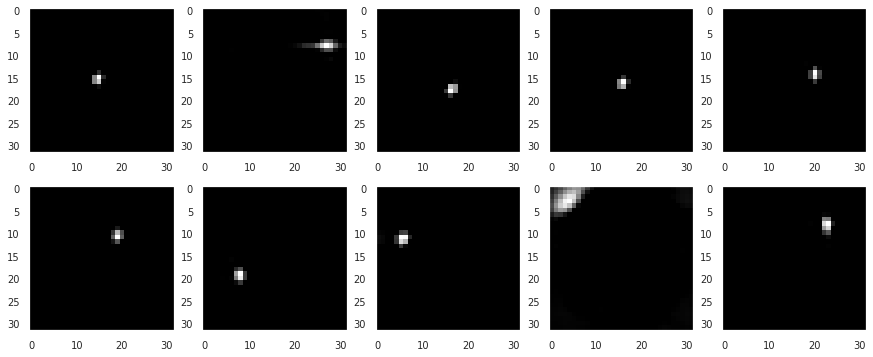

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for ax, component in zip(axes.flatten(), nmf1.components_[::20]):
    ax.imshow(component.reshape(32, 32), cmap="gray")
    ax.grid(None)

> Presentation of the components for a higher rank NMF

Unfortunately, this method was unable to detect the desired features. This was expected since, as previously seen, samples from the same class can look very differently.

## Generating new examples of underrepresented classes

Simple method for segmentation of the components didn't work for us, but using classic, expert based approach we can modify some of the classes to get more training data. We will focus on the second class - consonant diactric, since there is only 7 different classes.

Text(0.5, 1.0, 'consonant_diacritic')

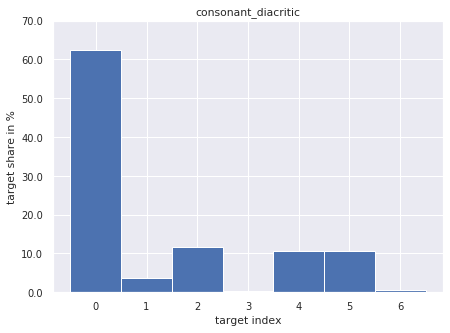

In [0]:
num_bins = [169, 12, 8]
idx_to_name = ['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']

plt.figure(figsize=(7, 5))
target_idx = 2

bins = num_bins[target_idx]

if bins < 20:
  bins = np.arange(bins)-0.5
else:
  bins = 20

plt.hist(Y_train[:, target_idx], density=True, bins=bins)

ticks = plt.yticks()[0]
new_ticks = np.round(ticks * 100, 1)
plt.yticks(ticks, new_ticks)

plt.ylabel('target share in %')
plt.xlabel('target index')

plt.title(idx_to_name[target_idx])

> Histogram of consonant diactric

From the histogram, we can see that tagets 1, 3 and 6 are underrepresented, we will try and generate more of them.
* 1: ঁ
* 3: র্য
* 6: ্র্য

We can see that the first one looks like it's easy to separate from the rest of the letter.

We will use heuristics designed for specific class to show that it is possible to generate more training data for an underrepresented class. As an example, we generate more data with target 1 in consonant diacritic. The heuristics use following ideas:
* this target is a hat above the letter, the rest of the letter remains unchanged
* the hat is in the upper part of the image
* hat consists of two connected components
* two connected components are rather small and close to each other

To present the effecivness of those heuristics, we compare original images with their modified versions.

![alt text](https://lh3.googleusercontent.com/v0Q3dl5auXiGuToreX221ZWLxPF5V1JG2hQ1YgBO1BTPH0m9QhACnaEV_lLNSK0VW3bYxbQX0Ki350ct2Z6SYTHqfFUTn-1Otoupn0lqCZdsXGu4S2MtP3WZS_6uS5L4BseZRUFrgy55J8CY0GJLC7tnZRgUHoOPpWmn0HAWQ3GzeBRe39WF-Zw7qbbpA8r9gL1pGKs2hD0HxK9HUrQKedI2FRVkDUWItmieyOT-pvs7YmdBoiuo2JYb-2nWNb62lBgsaCK__MYASg_Us9djOfn_y1PpIgGMi1W3_MV-e6nlmuj_P4S_qRDB2iQlFu1jWSwD43rnY6HmHjXA9hY7ejF9w6KSOcONRZDHlC1XkvQdbcT_bVz0plhiBtyY2oPnuoBU8WuTjlLVC5FRM6n8IIV0gZbYzrS2nKHnsZQsoacH470S09v0Flumne5VzXxic3CrobRhCa_MpEdw2w6KSzashG5sYZnjtbJjUWmc4-d9b_u8yTMIpdTWwKdyllHIuE7UJpbb8sp4XvNVHXBLfZf6roKajKw-9c0f89re72Y0iJSG-1jmJvcfTGW5stqPS3JplW4HMCt6HaG2rnFRUglAJfysVbPCztbIfI3kOoHMmaknUZyy703WrhiblsRvwNZKGHCIsuhy4jVB_AGVwpmEIEowQg0-hNsXHtAS5TLAD-E3uW5xBG5tNJBQkg=w1840-h960-ft)

> Results of heuristics for selecting target 1 (hat) of consonant diacritic

Targets of modified in such way should be changed from being target 2 to being target 0, which means no consonant diacritic at all. We can go further, and take the fragment of the image that was erased and try to put it on another image with target 0.
We stick to following heuristics:
* Add the fragment only if it is not overlapping with the rest of the letter
* Add the fragment only if pixel intensity (brightness) of the figure is similar between fragment and the rest of the letter
* Add the hat only to characters that naturally can have the hat (it was observed in the training set)

![alt text](https://lh3.googleusercontent.com/S8cPTr9Nfp2WZghYKlceKBE9KBVU9B9JQuYJgn8M__pei5v1dOf3Ow94IjBrGcBWEY9whE6DyvEiG9_UpOc-4vtMVac6V80-HI6zaQgVRt8kd0gfwQoIGx9B0_KUHmVBqdZqwK9KaSGbslhQZ6uDZSE_AYUtiO6OonZHRXX1BAbEYBMfRZ8NXa6IXVNkV4FsFrX-Wb0uDfaq2UCW4dflz7GVBQiyoEKXg_sHu9Ne_FxEfC9H-piSjcBIa462PDhY1ivG08apbJT1cPhk10Lb-KOzu8xh84GE9JzAQK-U1k-bO2u3yVcCO-Dmez7B2TsmAEUpVQ-UGkTWz7Vv6koT4la7JD4qTsG4BA9dB66F5cPhYsfcIH4thOmsbCi1hrMW_x6jQxS06Boyhab7no6GqCCjCxW4BYCvGu30bggP158a5z0z4RPYYVhhP1q96zvaNk9keu9wipAOPJrNorcpM17o1FZhTpopXFZNeGifE_OsZ-sfL_usPYZHziOX0i0JSRL3BPbiczdjpd35rK3OvmdAfVhnpDwPVCMwf_4Dx0SWlgMKyR7bQGCdc6Hemrw1QcwQNC0d7eShq4DLAHhKnEQqh3eoVsifCwYtujNn66X9TGLoLcRG_tPbNo61JKA994lZ82FaxdPhehhfbrec16Jl_zug3JJrorwHKl8_Nv8f1b1zWM7w6PplKV8iqg=w1840-h960-ft)

> Arificial data created using heurisitcs. The hat in the upper part of the image is taken from another letter and the rest of the letter stays unmodified.

The results look realistic. However this is only 1 from 3 underrepresented classes in consonant diacritic. Again, we selected this one, because it was the easiest to separate from the rest of the figure. Further experiments showed that models do not have problems with recogizing this class, since this class recall is high. Additinal data of this class is not very important. To improve the model, one should design heuristics for generating more data of problematic classes.

## Convolutional Neural Networks

**How good are nowaday neural networks for this task?**

Table shows error rates for different architectures and classes. These models were trained on downsampled images with 3 outputs at once. Macro recall is metric used in the competition as the leaderboard metric and is defined as $$\frac{1}{|L|} \sum_{l\in L} R(y_l, \text{model}(x_l))$$
for $L$ being a set of possible targets and $R$ is function calculating vanilla recall. Moreover, graphere root is twice as important as vowel diactric and consonant diactric for the competition leaderboard metric.

**Table of Results**

---

| Network | version | parameters | grapheme root | vowel diacritic | consonant diacritic | macro recall |
|:-|:-:|:-:|:-:|:-:|:-:|:-:|
| **ResNet 16-4** | base | 2.7M | 4.81% | - | - | - |
| **ResNet 16-4** | B | 2.7M | 4.30% | - | - | - |
| **ResNet 16-4** | B+C | 2.7M | 4.06% | - | - | - |
| **ResNet 28-2** | C | 1.6M | 3.99% | - | - | - |
| **ResNet 28-2** | C+D | 1.6M | 3.87% | - | - | - |
| **ResNet 112-4** | C+B | 27.0M | 3.23% | - | - | - |
| **ResNet 16-4** | D | 2.7M | 4.28% | 1.30% | 1.32% | 3.27% |
| **ResNet 22-8** | D | 17.2M | 3.79% | 1.10% | 1.17% | 2.91% |

> Various ResNets performance. Following columns: graphere root, vowel diactric and consonant diactric are error rates and macro recall is the competition metric described above.

Most of the experiments are focused on solving grapheme root prediction, since this is the most difficult and most important subtask in the competition.

There are ways to further improve the networks, but this is intended to be a sample of what networks are capable of. From the table we can infer the following:
* Deeper networks are better than wider
* Typical tricks, like cutout, work well

**Description of versions:**
* B: cutout was applied
* C: training on crops (75% of image size), testing on whole
* D: Generalized Mean Pooling instead of Average Pooling at the end of the network

**Description of the models:**

We use widened ResNets (Wide ResNet). For example, in name "ResNet 28-2", 28 is the number of layers in the network, including convolutionla shortcuts and dense layers and 2 is the widening factor with baseline width of 16-32-64 in consecutive parts of the network.

Text(0.5, 1.0, 'WRN-16-4 training')

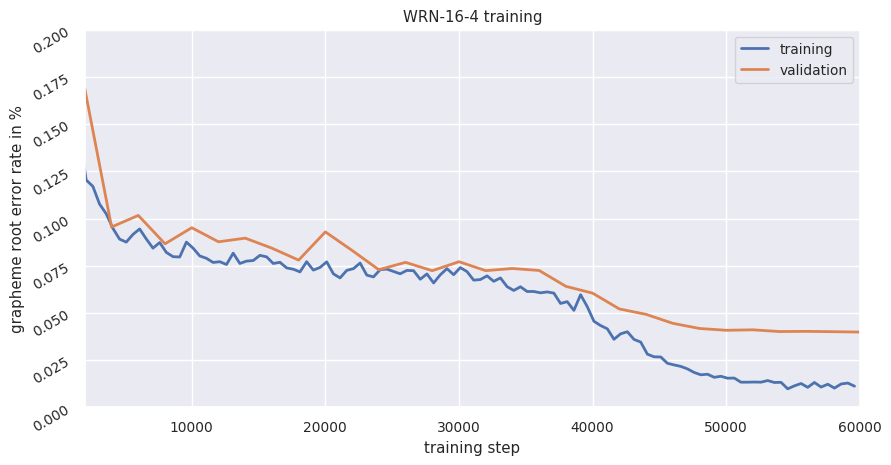

In [0]:
train = pd.read_csv('/content/gdrive/My Drive/ProjektML/train_curve.csv')
test = pd.read_csv('/content/gdrive/My Drive/ProjektML/test_curve.csv')

plt.figure(figsize=(10, 5), dpi=100)
plt.xlim(2000, 60000)
plt.ylim(0.0, 0.2)
plt.plot(train['Step'][::5], train['Value'][::5], label='training', linewidth=2)
plt.plot(test['Step'], test['Value'], label='validation', linewidth=2)
plt.legend()

plt.yticks(rotation=30)
plt.xlabel('training step')
plt.ylabel('grapheme root error rate in %')

plt.title('WRN-16-4 training')

> Target and validation error rates during examplanatory training for the grapheme root target

A few effective tricks that can further improve the training:
* Cosine or Hyperbolic Tangent Schedules
* Grid-Mask regularization (instead of cutout)
* Label smoothing
* Architectural modifications